# Simple ARIMA Model for Non-Seasonal Time-Series Forecast

Our goal in this challenge is to apply the basic concepts of time series analysis to one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

##  1. Load Data
Let's start by loading the Time Series of the challenge. Run the line below to download the dataset as a CSV file, then load the CSV in a DataFrame.

In [1]:
!curl https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/09-Time-Series/www_usage.csv > data/www_usage.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   377  100   377    0     0    868      0 --:--:-- --:--:-- --:--:--   868


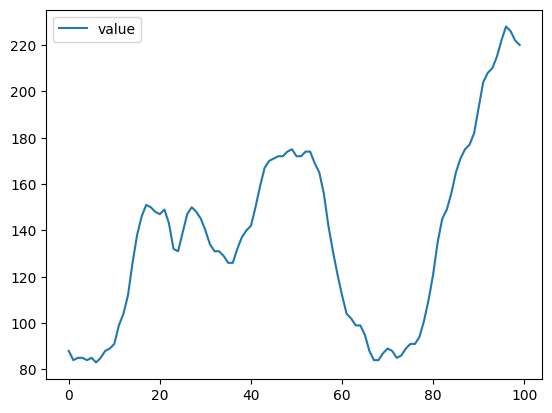

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/www_usage.csv', names=['value'], header=0)
y = df.value

df.plot();

This abstract time series does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regressive Moving Average (ARIMA) models.


## 2. Build ARIMA Model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time series (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the moving average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure Stationarity

ARIMA models apply to "stationary" time series only.

👉 Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [3]:
# YOUR CODE HERE
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(y)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')


ADF Statistic: -2.4642397172033688
p-value: 0.12441935447109453


The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat the process on the differentiated series if you want the *second difference*, etc...

👉 Find the minimum order of differencing we need to make it stationary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

ADF Statistic after differencing: -2.722238490442953
p-value after differencing: 0.07026846015272707


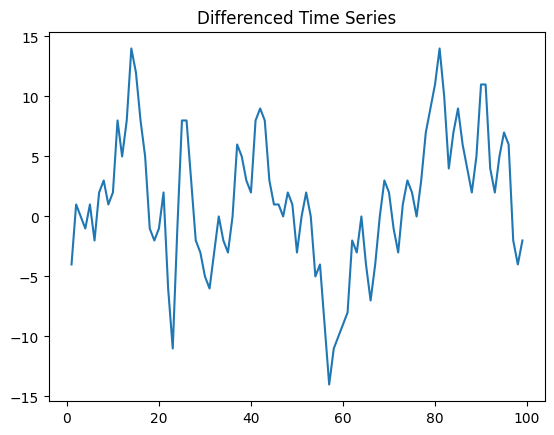

In [4]:
# YOUR CODE HERE
# Differencing the series to make it stationary
y_diff = y.diff().dropna()

# Checking if differencing was enough by re-running the ADF test
adf_result_diff = adfuller(y_diff)
print(f'ADF Statistic after differencing: {adf_result_diff[0]}')
print(f'p-value after differencing: {adf_result_diff[1]}')

# Plotting the differenced series
y_diff.plot()
plt.title("Differenced Time Series")
plt.show()


We have a close call here between one and two diff orders. Differentiating time series too much may also reduce the performance of your ARIMA models. Let's have a closer look:

👉 Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(💡Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

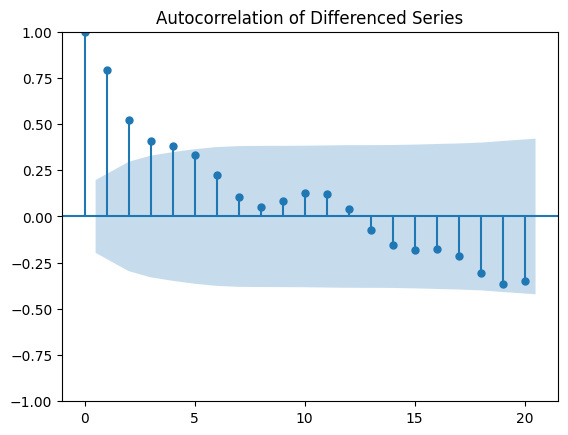

In [8]:
# YOUR CODE HERE
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plot_acf(y_diff)
plt.title("Autocorrelation of Differenced Series")
plt.show()


In our "second order diff" autocorrelation plot, the lag coefficient n°1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n°0 which is always equal to 1)

👉 Let's (tentatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

In [9]:
y_diff = y.diff().dropna()

We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary ("I" refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

👉 determine `q`

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

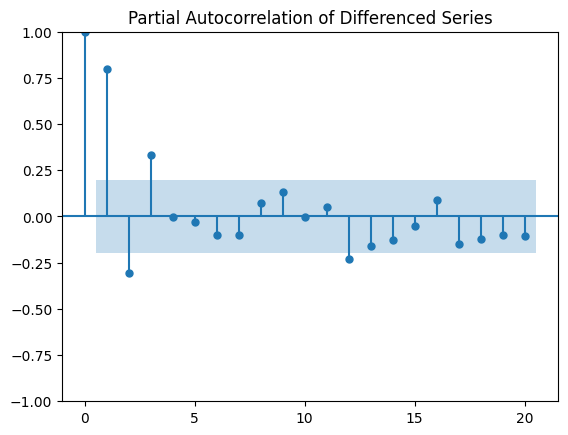

In [11]:

plot_pacf(y_diff)
plt.title("Partial Autocorrelation of Differenced Series")
plt.show()


The maximum value we should consider for fitting our model seems to be q = 4. However, if we were to use Auto-ARIMA (more on this later) we would find that using q=2 yields ideal results so to begin with, let's try setting q=2. 

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

👉 Determine `p`

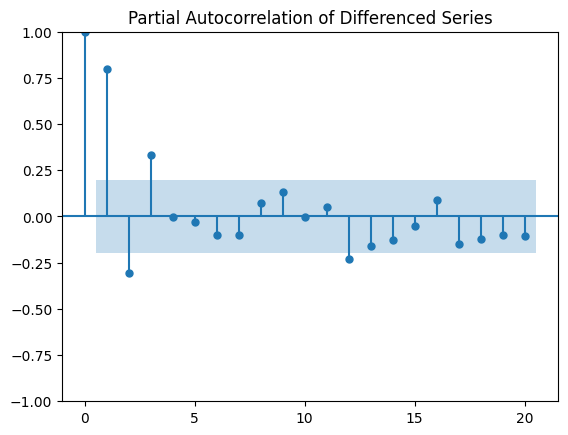

In [12]:
# YOUR CODE HERE
# Plot PACF to find the autoregressive (AR) order (p)
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(y_diff, lags=20)
plt.title("Partial Autocorrelation of Differenced Series")
plt.show()


We could choose `p = 3` as the first 3 lag terms seem above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d`, and `q` for the ARIMA, 

👉 build the `arima_model` from `statsmodels`.
- fit the model
- print the model (`.summary`)

In [13]:
# YOUR CODE HERE
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (using p=1, d=1, q=2 as determined from ACF/PACF)
model = ARIMA(y, order=(1, 1, 2))
arima_result = model.fit()

# Print summary
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Sun, 29 Sep 2024   AIC                            516.253
Time:                        08:28:37   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.6

☝️ If your p-values are too high, try to remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate the overall performance of your fit by minimizing the [`AIC - Akaike Information Criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remain low) and maintain a quasi-similar AIC score than other models

## 3. Evaluate model performance

👉 Visualize your model predictions with the `plot_predict()` method

- Look closely at the method default params, especially `dynamic` ones. 
- Do you think your model would have such a good performance in reality?

In [14]:
from statsmodels.graphics.tsaplots import plot_predict

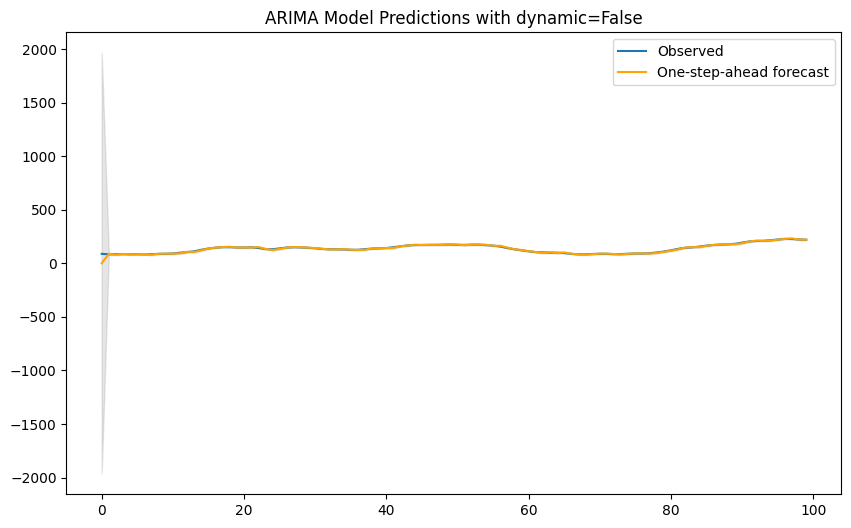

In [16]:
# YOUR CODE HERE
# Generate predictions for the in-sample data (e.g., the data the model was trained on)
predictions = arima_result.get_prediction()

# Confidence intervals for the predictions
pred_ci = predictions.conf_int()

# Plot observed data and predictions
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(y.index, y, label='Observed')

# Plot the predicted mean values
ax.plot(predictions.predicted_mean.index, predictions.predicted_mean, label='One-step-ahead forecast', color='orange')

# Plot the confidence intervals
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='gray', alpha=0.2)

# Add title and show the plot
plt.title("ARIMA Model Predictions with dynamic=False")
plt.legend()
plt.show()


☝️ `dynamic=False` makes use of all available values `y` to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

👉 Try to use `dynamic=True` to plot a prediction of the _last 15 values_ in a situation where the model only has _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ its previously predicted value for 86
- etc...iteratively until 100

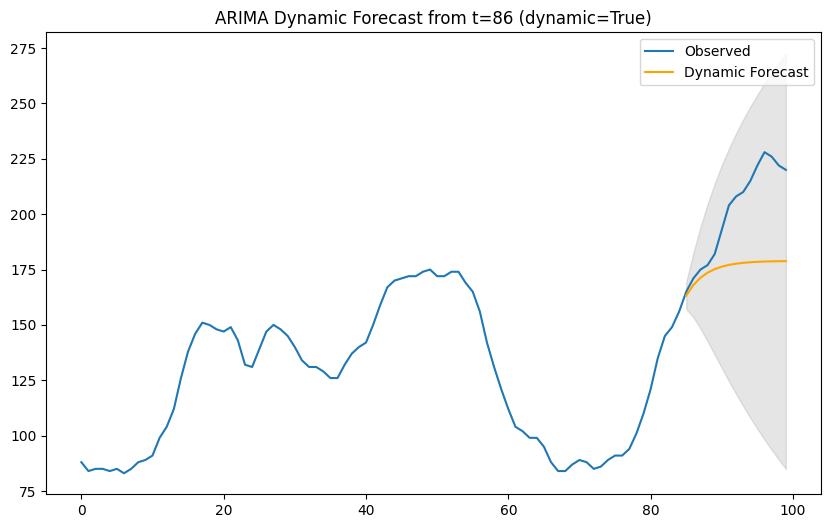

In [17]:
# YOUR CODE HERE
# Generate predictions for the entire range but with dynamic=True after t=85
dynamic_start = 85

# Generate dynamic predictions starting from index 85
dynamic_predictions = arima_result.get_prediction(start=dynamic_start, dynamic=True)

# Get confidence intervals for the dynamic predictions
dynamic_ci = dynamic_predictions.conf_int()

# Plot observed data and dynamic predictions
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(y.index, y, label='Observed')

# Plot the dynamically predicted mean values starting from 86 to 100
ax.plot(dynamic_predictions.predicted_mean.index, dynamic_predictions.predicted_mean, label='Dynamic Forecast', color='orange')

# Plot the confidence intervals for the dynamic forecast
ax.fill_between(dynamic_ci.index, dynamic_ci.iloc[:, 0], dynamic_ci.iloc[:, 1], color='gray', alpha=0.2)

# Add title and show the plot
plt.title("ARIMA Dynamic Forecast from t=86 (dynamic=True)")
plt.legend()
plt.show()


☝️ That's still not a _true_ forecast! Why?

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` series during the fitting phase!
</details>

### 3.1 Out-of-Sample Forecasts (real "future")

👉 Create a train-test-split keep the last 15 data points only for the test set, and train your ARIMA on the train set only.

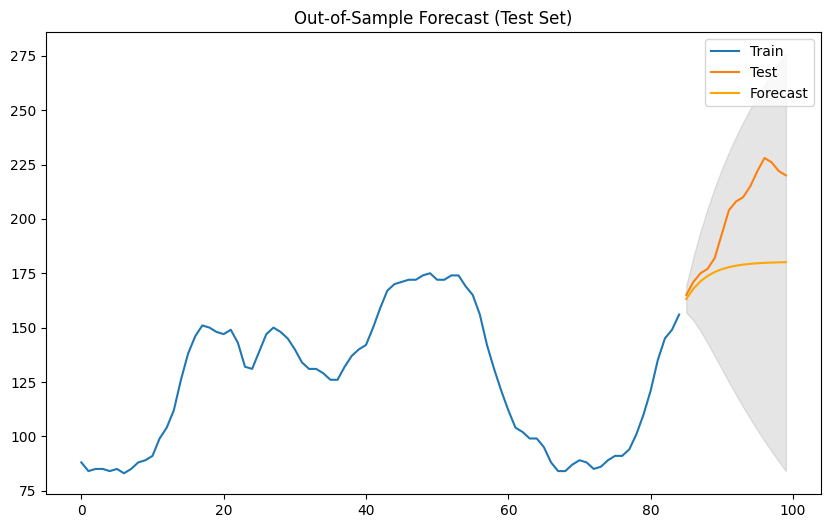

In [18]:
# YOUR CODE HERE

# Step 1: Split the data
train = y[:85]  # First 85 points for training
test = y[85:]   # Last 15 points for testing

# Step 2: Train ARIMA on the train set only
# Using the same order you determined earlier (e.g., p=1, d=1, q=2)
model_train = ARIMA(train, order=(1, 1, 2))
arima_train_result = model_train.fit()

# Step 3: Forecast the next 15 points (test set)
forecast_results = arima_train_result.get_forecast(steps=15)

# Get the predicted values and confidence intervals for the forecast
forecast = forecast_results.predicted_mean
forecast_ci = forecast_results.conf_int()

# Step 4: Plot the train, test, and forecasted values
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the training data
ax.plot(train.index, train, label='Train')

# Plot the test data
ax.plot(test.index, test, label='Test')

# Plot the forecasted values
ax.plot(forecast.index, forecast, label='Forecast', color='orange')

# Plot the confidence intervals for the forecast
ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)

# Add title and show the plot
plt.title("Out-of-Sample Forecast (Test Set)")
plt.legend()
plt.show()


👉 We are "now" in step 85 and have never seen the future:
- Use the `get_forecast()` method on your fitted `arima` model to "forecast" the 15 next data points (i.e beyond the end of your train dataset) 

The method returns a `PredictionResultsWrapper` object from `statsmodels`.

**💻 Store this result in a variable named `forecast_results`.**  

It is hard to navigate at first, but here are some tips:
- You can find your forecasts in `forecast_results.predicted_mean`
- Your confidence intervals are given by `forecast_results.conf_int()`

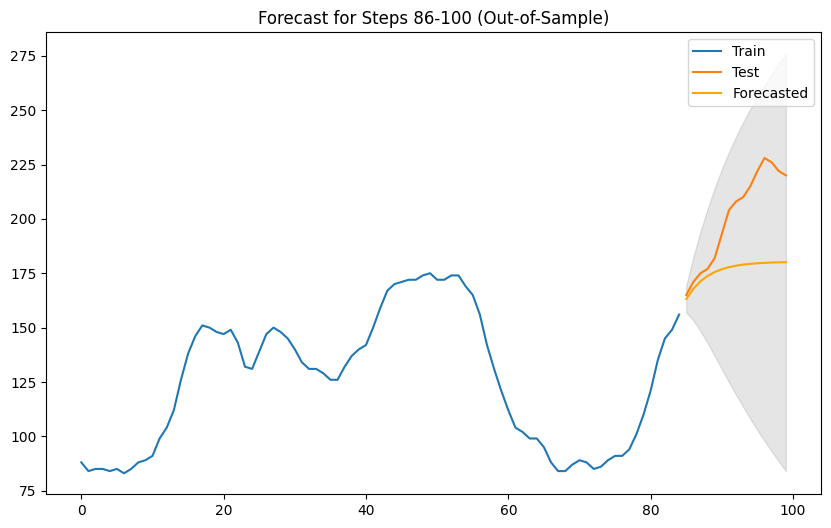

Forecasted Values (Mean):
85    163.126755
86    167.854337
87    171.278008
88    173.757399
89    175.552951
90    176.853273
91    177.794954
92    178.476911
93    178.970778
94    179.328432
95    179.587441
96    179.775014
97    179.910852
98    180.009224
99    180.080465
Name: predicted_mean, dtype: float64

Confidence Intervals:
    lower value  upper value
85   156.900942   169.352568
86   153.293167   182.415506
87   148.418246   194.137770
88   142.816329   204.698468
89   136.886104   214.219798
90   130.871575   222.834970
91   124.917263   230.672645
92   119.105583   237.848239
93   113.480284   244.461271
94   108.061162   250.595701
95   102.853356   256.321527
96    97.853260   261.696767
97    93.052287   266.769416
98    88.439252   271.579197
99    84.001859   276.159071


In [19]:
# YOUR CODE HERE

# Step 1: Split the data into train (first 85 points) and test (last 15 points)
train = y[:85]  # Training set
test = y[85:]   # Test set (for comparison, but we won't use it in training)

# Step 2: Fit the ARIMA model to the train data only
model_train = ARIMA(train, order=(1, 1, 2))  # Assuming (1, 1, 2) as the ARIMA order
arima_train_result = model_train.fit()

# Step 3: Forecast the next 15 points (beyond the train set, i.e., steps 86-100)
forecast_results = arima_train_result.get_forecast(steps=15)

# Step 4: Extract the forecasted mean values
forecast_mean = forecast_results.predicted_mean

# Step 5: Extract the confidence intervals
forecast_ci = forecast_results.conf_int()

# Step 6: Plot the results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the true values for the train and test sets
ax.plot(train.index, train, label='Train')
ax.plot(test.index, test, label='Test')

# Plot the forecasted values (steps 86-100)
ax.plot(forecast_mean.index, forecast_mean, label='Forecasted', color='orange')

# Plot the confidence intervals for the forecasted values
ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)

# Add title and show the plot
plt.title("Forecast for Steps 86-100 (Out-of-Sample)")
plt.legend()
plt.show()

# Optionally, print the forecasted values and confidence intervals
print("Forecasted Values (Mean):")
print(forecast_mean)

print("\nConfidence Intervals:")
print(forecast_ci)


👉 Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

👉 Try to also plot your previous 85 `y` real data points to better grasp model performance relative to the past

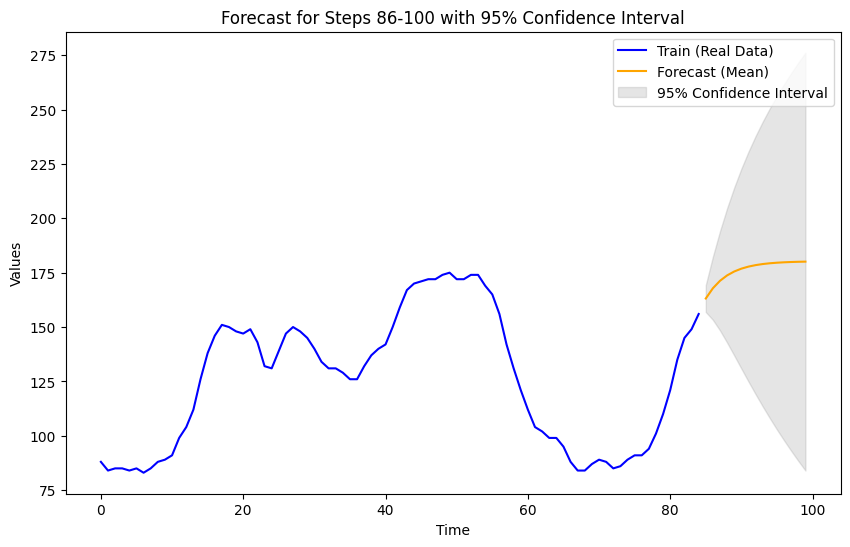

In [20]:
# YOUR CODE HERE

# Step 1: Split the data into train (first 85 points) and test (last 15 points)
train = y[:85]  # Training set
test = y[85:]   # Test set (for comparison, but not used in training)

# Step 2: Fit the ARIMA model to the train data only
model_train = ARIMA(train, order=(1, 1, 2))  # Assuming (1, 1, 2) as the ARIMA order
arima_train_result = model_train.fit()

# Step 3: Forecast the next 15 points (beyond the train set, i.e., steps 86-100)
forecast_results = arima_train_result.get_forecast(steps=15)

# Step 4: Extract the forecasted mean values and confidence intervals
forecast_mean = forecast_results.predicted_mean
forecast_ci = forecast_results.conf_int()

# Step 5: Plot the previous 85 points (real data) and forecasted values with 95% confidence intervals

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the training data (first 85 real data points)
ax.plot(train.index, train, label='Train (Real Data)', color='blue')

# Plot the forecasted values (steps 86-100)
ax.plot(forecast_mean.index, forecast_mean, label='Forecast (Mean)', color='orange')

# Plot the confidence intervals for the forecast
ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')

# Add title and labels
plt.title("Forecast for Steps 86-100 with 95% Confidence Interval")
plt.xlabel('Time')
plt.ylabel('Values')

# Add a legend
plt.legend()

# Show the plot
plt.show()


### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

👉 Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals anyway if you want)

Note: residuals are constructed by 'seeing' all data as in `plot_predict(dynamic=False)`

Also, try to plot a histogram or KDE fit of the residuals to see if they are approximately normally distributed.

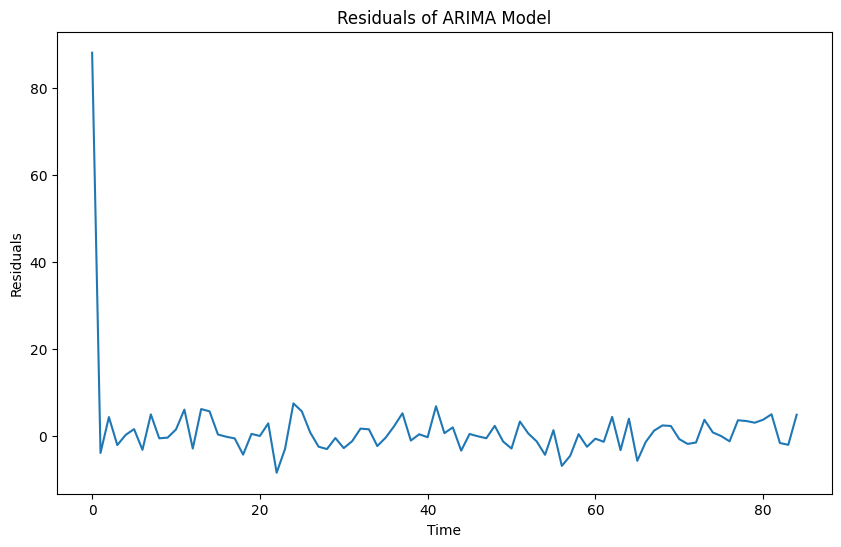

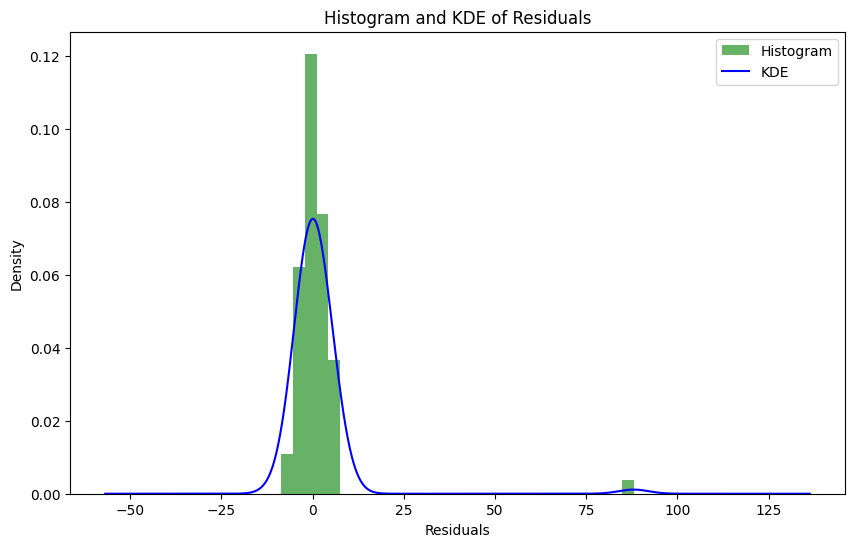

<Figure size 1000x600 with 0 Axes>

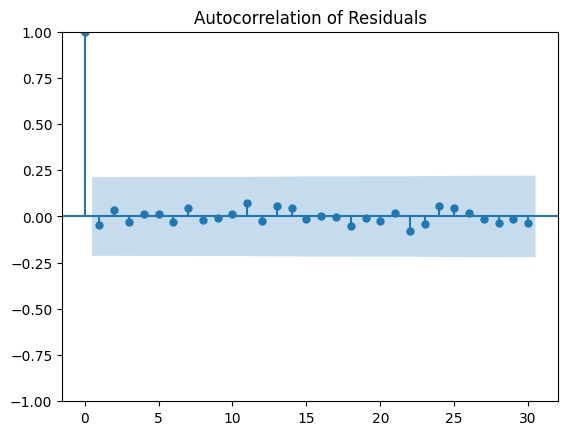

Mean of residuals: 1.258963547689784
Variance of residuals: 100.83837451497755


In [21]:
# YOUR CODE HERE

# Step 1: Plot the residuals to check for patterns
residuals = arima_train_result.resid

# Plot the residuals over time
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title("Residuals of ARIMA Model")
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Step 2: Check for normal distribution of residuals using histogram and KDE
plt.figure(figsize=(10, 6))

# Plot histogram of residuals
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g', label='Histogram')

# Plot Kernel Density Estimate (KDE)
residuals.plot(kind='kde', label='KDE', color='blue')

plt.title("Histogram and KDE of Residuals")
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()

# Step 3: Check for autocorrelation in the residuals
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=30)
plt.title("Autocorrelation of Residuals")
plt.show()

# Step 4: Print basic statistics of residuals to check for mean zero
print(f"Mean of residuals: {residuals.mean()}")
print(f"Variance of residuals: {residuals.var()}")


## 3.3 Cross-validated performance metrics

👉 Below are the most common performance metrics for time series

In [22]:
import numpy as np
from statsmodels.tsa.stattools import acf

def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:

    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'acf1':acf1,
        'corr':corr,
        'minmax':minmax
    })

    return forecast

👉 Play with your ARIMA hyper-parameters and see the impact on your forecast performance

ARIMA(1, 1, 1) - AIC: 440.10941266911607, BIC: 447.401863065646


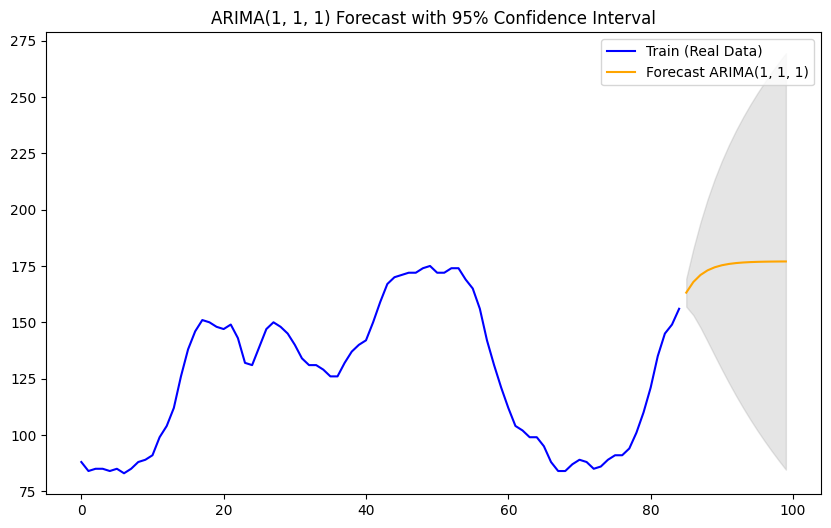

ARIMA(2, 1, 2) - AIC: 443.51636853985286, BIC: 455.67045253406945


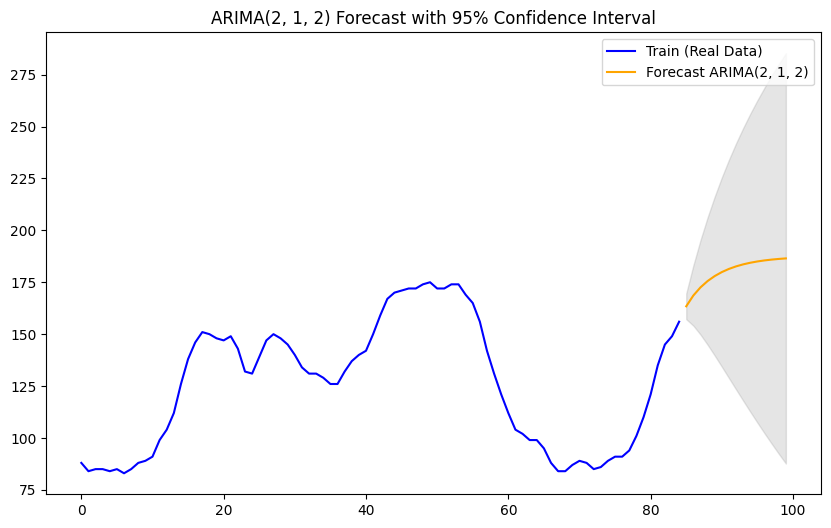

ARIMA(3, 1, 0) - AIC: 440.3290950473065, BIC: 450.05236224267975


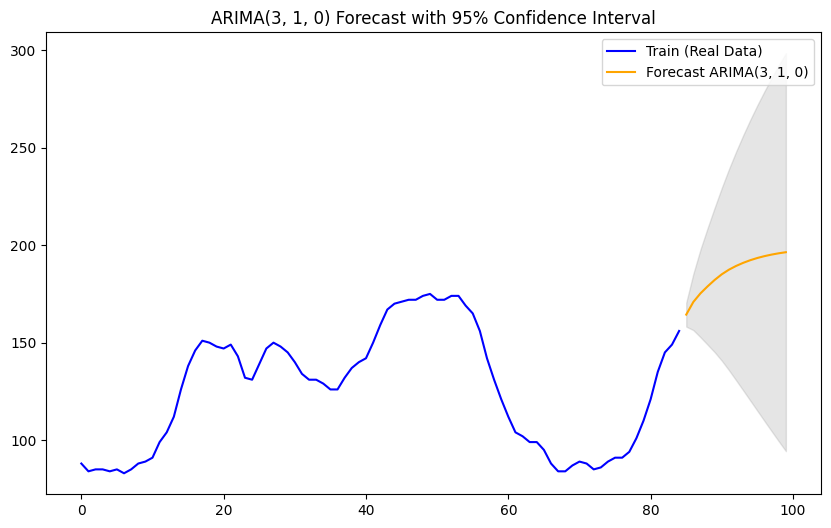

ARIMA(1, 2, 1) - AIC: 445.82036910253555, BIC: 453.07689092592534


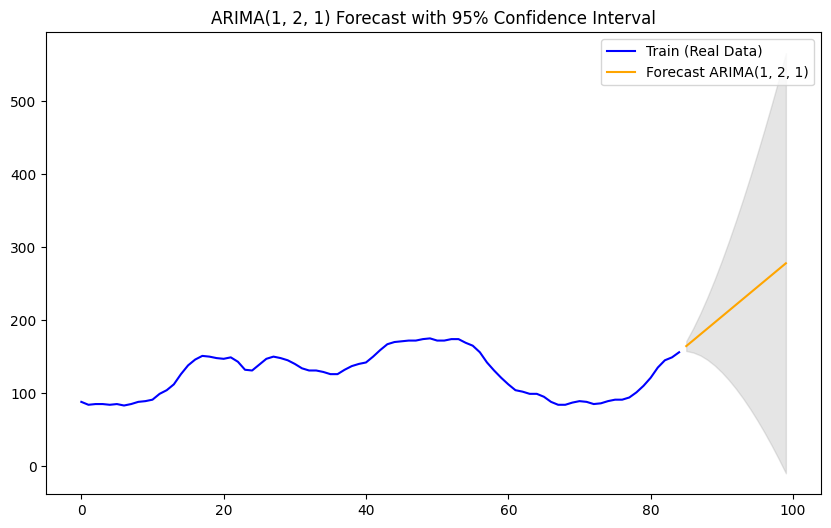

In [23]:
# YOUR CODE HERE

from statsmodels.tsa.arima.model import ARIMA

# Step 1: Define a function to evaluate ARIMA models with different parameters
def evaluate_arima_model(train_data, p, d, q):
    # Fit ARIMA model with given parameters (p, d, q)
    model = ARIMA(train_data, order=(p, d, q))
    model_result = model.fit()

    # Print model summary including AIC and BIC
    print(f"ARIMA({p}, {d}, {q}) - AIC: {model_result.aic}, BIC: {model_result.bic}")
    
    # Generate forecast for the next 15 points
    forecast_result = model_result.get_forecast(steps=15)
    
    # Plot forecasted values and confidence intervals
    forecast_mean = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int()

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training data
    ax.plot(train.index, train, label='Train (Real Data)', color='blue')

    # Plot forecasted values
    ax.plot(forecast_mean.index, forecast_mean, label=f'Forecast ARIMA({p}, {d}, {q})', color='orange')

    # Plot confidence intervals
    ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)

    # Add labels and legend
    plt.title(f"ARIMA({p}, {d}, {q}) Forecast with 95% Confidence Interval")
    plt.legend()
    plt.show()

# Step 2: Try different combinations of (p, d, q) and compare results

# Example 1: ARIMA(1, 1, 1)
evaluate_arima_model(train, p=1, d=1, q=1)

# Example 2: ARIMA(2, 1, 2)
evaluate_arima_model(train, p=2, d=1, q=2)

# Example 3: ARIMA(3, 1, 0)
evaluate_arima_model(train, p=3, d=1, q=0)

# Example 4: ARIMA(1, 2, 1)
evaluate_arima_model(train, p=1, d=2, q=1)


## 4 Grid Search

Try to run a Grid Search for (p,d,q) using `pmdarima`. Use at least
- `test='adf'`
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [25]:
# Step 1: Define the train and test sets
y_train = y[:85]  # Training set (first 85 points)
y_test = y[85:]   # Test set (last 15 points)

# Step 2: Run the auto_arima function on y_train
import pmdarima as pm

model = pm.auto_arima(
    y_train,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,           # let model determine 'd'
    test='adf',       # using adf test to find optimal 'd'
    trace=True, error_action='ignore',  suppress_warnings=True
)

# Print the summary of the model
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=449.662, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=449.569, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=445.819, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=445.820, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=441.300, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=438.613, Time=0.02 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=440.036, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=440.231, Time=0.03 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 0.410 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:               SARIMAX(0, 2, 3)   Log Likelihood                -215.307
Date:                Sun, 29 Sep 2024   AIC                   

In [26]:
import pmdarima as pm

model = pm.auto_arima(
    y_train,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,           # let model determine 'd'
    test='adf',       # using adf test to find optimal 'd'
    trace=True, error_action='ignore',  suppress_warnings=True
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=449.662, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=449.569, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=445.819, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=445.820, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=441.300, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=438.613, Time=0.02 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=440.036, Time=0.03 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=440.231, Time=0.03 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 0.248 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:               SARIMAX(0, 2, 3)   Log Likelihood                -215.307
Date:                Sun, 29 Sep 2024   AIC                   

## (Optional) Cross-validate the Performance of your Model

In practice, results and Grid Search should always be cross-validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create contiguous K-folds to truly evaluate the performance of your model and find the best hyperparams after cross-validation.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png'>

**ARIMA - Cross-Validation using TimeSeriesSplit + Grid Search**

In [27]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import pmdarima as pm

# Step 1: Define the time series split object
tscv = TimeSeriesSplit(n_splits=5)

# Step 2: Track model performance across splits
aic_scores = []
rmse_scores = []

# Step 3: Perform TimeSeriesSplit cross-validation
for train_index, test_index in tscv.split(y):
    # Split the data into training and testing sets for this fold
    y_train, y_test = y[train_index], y[test_index]
    
    # Step 4: Fit the ARIMA model using auto_arima for each fold
    model = pm.auto_arima(
        y_train,
        start_p=0, max_p=3,
        start_q=0, max_q=3,
        d=None,           # let auto_arima determine 'd'
        test='adf',       # use ADF test to find optimal 'd'
        trace=False, error_action='ignore', suppress_warnings=True
    )
    
    # Step 5: Make predictions on the test set
    y_pred = model.predict(n_periods=len(y_test))
    
    # Step 6: Calculate performance metrics
    aic_scores.append(model.aic())
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

# Step 7: Print the cross-validated performance metrics
print(f"Mean AIC across folds: {np.mean(aic_scores)}")
print(f"Mean RMSE across folds: {np.mean(rmse_scores)}")


Mean AIC across folds: 269.5797384013651
Mean RMSE across folds: 36.51603955722369


In [29]:
import pandas as pd

# Create an empty list to store results
results = []

# Define the different ARIMA configurations to try (you can change these)
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]

# Perform a grid search over the ARIMA parameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit the ARIMA model
                model = pm.auto_arima(
                    y_train,
                    order=(p, d, q),
                    trace=False,
                    error_action='ignore',
                    suppress_warnings=True
                )
                
                # Append the results (p, d, q and AIC) to the list
                results.append({
                    '(p, d, q)': (p, d, q),
                    'AIC': model.aic()
                })
                
            except Exception as e:
                # If the model fails to fit, ignore it and move on
                continue

# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Display the DataFrame
print(df)


    (p, d, q)         AIC
0   (0, 0, 0)  442.105158
1   (0, 0, 1)  442.105158
2   (0, 0, 2)  442.105158
3   (0, 1, 0)  442.105158
4   (0, 1, 1)  442.105158
5   (0, 1, 2)  442.105158
6   (1, 0, 0)  442.105158
7   (1, 0, 1)  442.105158
8   (1, 0, 2)  442.105158
9   (1, 1, 0)  442.105158
10  (1, 1, 1)  442.105158
11  (1, 1, 2)  442.105158
12  (2, 0, 0)  442.105158
13  (2, 0, 1)  442.105158
14  (2, 0, 2)  442.105158
15  (2, 1, 0)  442.105158
16  (2, 1, 1)  442.105158
17  (2, 1, 2)  442.105158


In [30]:
# Sort the DataFrame by AIC and group by ARIMA order (p, d, q)
df_sorted = df.sort_values('AIC').groupby('(p, d, q)').mean()['AIC'].sort_values()

# Display the sorted DataFrame
print(df_sorted)


(p, d, q)
(0, 0, 0)    442.105158
(2, 1, 0)    442.105158
(2, 0, 2)    442.105158
(2, 0, 1)    442.105158
(2, 0, 0)    442.105158
(1, 1, 2)    442.105158
(1, 1, 1)    442.105158
(1, 1, 0)    442.105158
(1, 0, 2)    442.105158
(1, 0, 1)    442.105158
(1, 0, 0)    442.105158
(0, 1, 2)    442.105158
(0, 1, 1)    442.105158
(0, 1, 0)    442.105158
(0, 0, 2)    442.105158
(0, 0, 1)    442.105158
(2, 1, 1)    442.105158
(2, 1, 2)    442.105158
Name: AIC, dtype: float64


In [31]:
df.sort_values('AIC').groupby('(p, d, q)').mean()['AIC'].sort_values()

(p, d, q)
(0, 0, 0)    442.105158
(2, 1, 0)    442.105158
(2, 0, 2)    442.105158
(2, 0, 1)    442.105158
(2, 0, 0)    442.105158
(1, 1, 2)    442.105158
(1, 1, 1)    442.105158
(1, 1, 0)    442.105158
(1, 0, 2)    442.105158
(1, 0, 1)    442.105158
(1, 0, 0)    442.105158
(0, 1, 2)    442.105158
(0, 1, 1)    442.105158
(0, 1, 0)    442.105158
(0, 0, 2)    442.105158
(0, 0, 1)    442.105158
(2, 1, 1)    442.105158
(2, 1, 2)    442.105158
Name: AIC, dtype: float64

☝️ Our initial choice of model (1, 1, 2) is not so bad!
Notice that the dataset (100 data points) is in reality way too small to cross-validate anything!